In [1]:
!pip install cirq --quiet
import cirq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.5/597.5 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.1/425.1 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 63.2 MB/s eta 0:00:00


In [2]:
num_qubits = 7

wlist = [
    [0, 6, 0.9676], [1, 5, 0.9575], [2, 4, 0.9746], [1, 6, 0.9974],
    [2, 5, 1.0208], [3, 4, 1.0625], [1, 0, 0.9986], [2, 6, 0.9778],
    [3, 5, 0.9694], [2, 0, 0.9474], [3, 6, 1.0100], [4, 5, 0.9612],
    [2, 1, 0.9693], [3, 0, 0.9972], [4, 6, 0.9999], [3, 1, 1.0383],
    [4, 0, 0.9960], [5, 6, 0.9663], [3, 2, 0.9808], [4, 1, 1.0240],
    [5, 0, 0.9382]
]

ws = [
    -0.4273, -2.1533, -0.3372, -0.7180,
    -1.0090, -0.6296, -1.1775
]

theta = [
    0.1588, 0.2473, 2.5624, -0.0291
]


In [3]:
def qaoa_with_mirror_swaps_1d(theta, measure=True):
    """QAOA circuit on 1D qubits with mirror symmetric swap layers after each layer."""
    qubits = [cirq.LineQubit(i) for i in range(num_qubits)]
    circuit = cirq.Circuit()

    circuit.append(cirq.H.on_each(*qubits))

    j = 0
    while j < len(theta):
        gamma = theta[j]
        for w in wlist:
            q0, q1, weight = w
            circuit.append(cirq.CNOT(qubits[q0], qubits[q1]))
            circuit.append(cirq.rz(2.0 * gamma * weight).on(qubits[q1]))
            circuit.append(cirq.CNOT(qubits[q0], qubits[q1]))
        for i in range(num_qubits):
            circuit.append(cirq.rz(2.0 * gamma * ws[i]).on(qubits[i]))

        j += 1
        beta = theta[j]
        for i in range(num_qubits):
            circuit.append(cirq.rx(-2.0 * beta).on(qubits[i]))

        # Swap layer with mirror symmetry
        for i in range(num_qubits // 2):
            circuit.append(cirq.SWAP(qubits[i], qubits[num_qubits - 1 - i]))

        j += 1

    if measure:
        circuit.append(cirq.measure(*qubits, key='result'))

    return circuit, qubits

In [6]:
circuit, qubits = qaoa_with_mirror_swaps_1d(theta)

print(circuit)

          ┌───┐                ┌───┐   ┌───┐                ┌───┐   ┌──┐                ┌──┐   ┌──┐                ┌──┐   ┌──┐                ┌──┐   ┌──┐                ┌──┐   ┌─────────────┐                 ┌───┐                               ┌───┐   ┌───┐               ┌───┐   ┌───┐               ┌───┐   ┌──┐               ┌──┐   ┌──┐               ┌──┐   ┌──┐               ┌──┐   ┌──┐               ┌──┐   ┌────────────┐                ┌───┐                              ┌───┐
0: ───H────@────────────────────@────────────────────────────────────X─────Rz(0.101π)────X──────X─────Rz(0.096π)────X───────X────Rz(0.101π)─────X──────X────Rz(0.101π)─────X─────────────────X────Rz(0.095π)───────X────Rz(-0.043π)───Rx(-0.157π)────×───────@───────────────────@───────────────────────────────────X─────Rz(1.63π)────X──────X─────Rz(1.54π)────X───────X────Rz(1.63π)─────X──────X────Rz(1.63π)─────X────────────────X────Rz(1.53π)───────X────Rz(-0.697π)───Rx(0.019π)────×──────M('result')───
           │     

In [7]:
# Noise model
noise_model = cirq.ConstantQubitNoiseModel(cirq.depolarize(p=0.01))

ideal_simulator = cirq.Simulator()
noisy_simulator = cirq.DensityMatrixSimulator(noise=noise_model)

In [8]:
def compute_fidelity(circuit):
    ideal_result = ideal_simulator.simulate(circuit)
    ideal_state = ideal_result.final_state_vector

    noisy_result = noisy_simulator.simulate(circuit)
    noisy_dm = noisy_result.final_density_matrix

    fidelity = np.real(np.dot(ideal_state.conj().T, noisy_dm @ ideal_state))
    return fidelity

Fidelity between ideal and noisy states (1D + swap layers + mirror symmetry): 0.0673


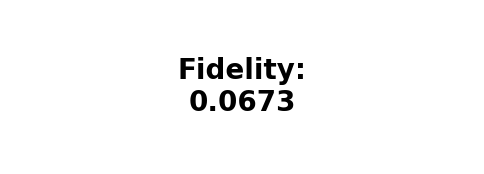

In [9]:
# Circuit (no measurement for fidelity)
circuit_no_measure, qubits = qaoa_with_mirror_swaps_1d(theta, measure=False)

# Fidelity
fidelity = compute_fidelity(circuit_no_measure)
print(f"\033[1mFidelity between ideal and noisy states (1D + swap layers + mirror symmetry): {fidelity:.4f}\033[0m")

plt.figure(figsize=(6, 2))
plt.text(0.5, 0.5,
         f"Fidelity:\n{fidelity:.4f}",
         ha='center', va='center',
         fontsize=20, fontweight='bold')
plt.axis('off')
plt.show()

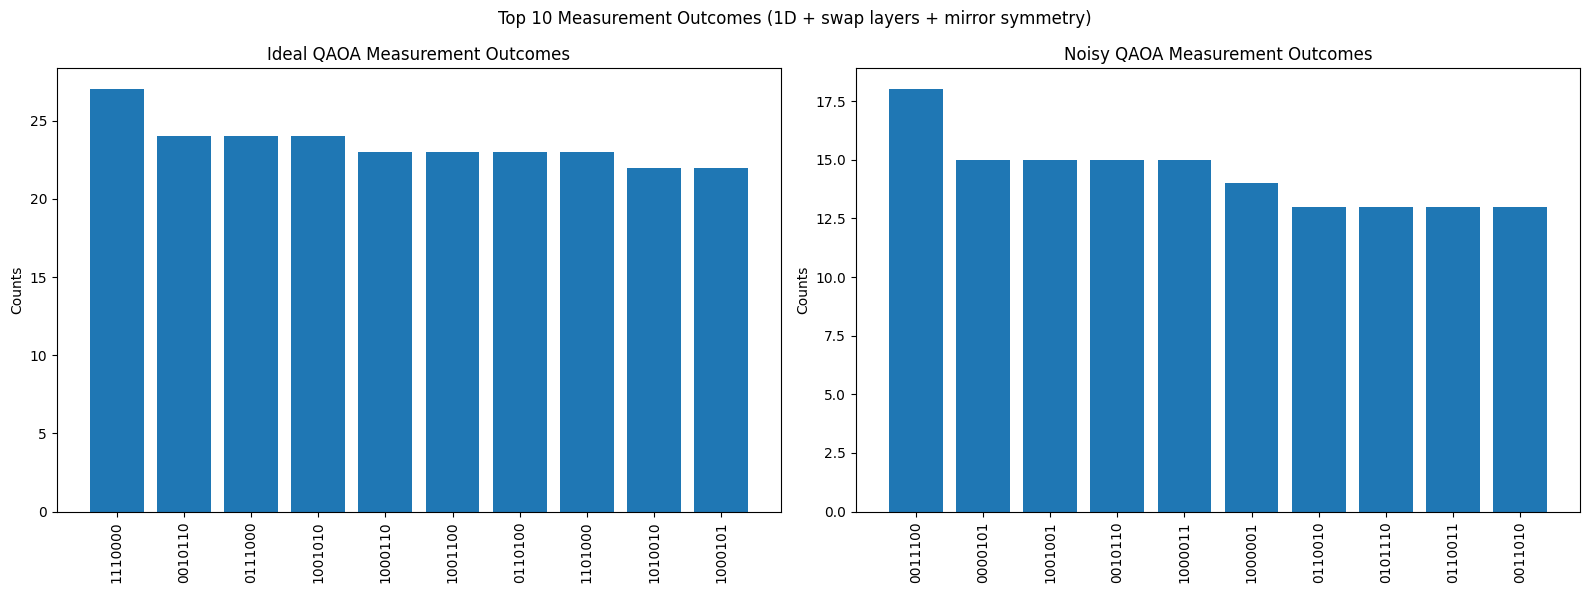

In [10]:
# Circuit (with measurement for histograms)
circuit_measure, _ = qaoa_with_mirror_swaps_1d(theta, measure=True)

# Run ideal simulation with measurement
ideal_result = ideal_simulator.run(circuit_measure, repetitions=1000)
hist_ideal = ideal_result.histogram(key='result')

# Run noisy simulation with measurement
noisy_result = noisy_simulator.run(circuit_measure, repetitions=1000)
hist_noisy = noisy_result.histogram(key='result')

# Format data for plotting
def get_top_counts(hist):
    bitstrings = [format(k, f'0{num_qubits}b') for k in hist.keys()]
    counts = list(hist.values())
    df = pd.DataFrame({'bitstring': bitstrings, 'counts': counts})
    df_sorted = df.sort_values(by='counts', ascending=False).head(10)
    return df_sorted

df_ideal = get_top_counts(hist_ideal)
df_noisy = get_top_counts(hist_noisy)

# Plot both
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].bar(df_ideal['bitstring'], df_ideal['counts'])
axs[0].set_title("Ideal QAOA Measurement Outcomes")
axs[0].set_ylabel("Counts")
axs[0].tick_params(axis='x', rotation=90)

axs[1].bar(df_noisy['bitstring'], df_noisy['counts'])
axs[1].set_title("Noisy QAOA Measurement Outcomes")
axs[1].set_ylabel("Counts")
axs[1].tick_params(axis='x', rotation=90)

plt.suptitle("Top 10 Measurement Outcomes (1D + swap layers + mirror symmetry)")
plt.tight_layout()
plt.show()